# 2024_CA683I assignment

**Code references (tutorials/documentation):**

*   https://www.datacamp.com/tutorial/text-analytics-beginners-nltk
*   https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
* https://medium.com/@skillcate/sentiment-analysis-using-nltk-vader-98f67f2e6130
* https://www.kaggle.com/code/sermakarevich/sklearn-pipelines-tutorial
* https://pyimagesearch.com/2021/05/17/introduction-to-hyperparameter-tuning-with-scikit-learn-and-python/
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

**Dataset:**


*   https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023




# Business understanding and use case



*   Main goal is to create a model for sentiment detection, that will be used to analyse longer text pieces (articles, multi paragraph text, or a multi paragraph length opinion pieces)
* Model will be used to analyse product reviews - text pieces that might have mixed sentiment accross the full text.  
* The focus is longer text pieces - this is important as training and final model needs to reflact that. Detection of a sentiment of a few word short sentences is less valuable in this context.
* We also dont want a document level sentiment detection model as the usual product reviews will contain sentiment about multiple aspects of the product - we want to get a aggregated sentiment metric that shows the sentiment spread accross multiple aspects not just positive/negative for the whole document.



# Step 0 - Dependency installation and import

In [1]:
!pip install datasets
!pip install pandas

!pip install spacy
!python -m spacy download en_core_web_sm
!pip install pandarallel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
  

In [2]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import combinations
import statsmodels.stats.multitest as multitest
from scipy.stats import spearmanr
from scipy.stats import kruskal
from scipy import stats

import re
import spacy
from pandarallel import pandarallel

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import f1_score

from sklearn import metrics

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import multiprocessing
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader as api

from sklearn.pipeline import Pipeline

# Step 1 - Data loading

In [3]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)
#dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Electronics", trust_remote_code=True)
print(dataset["full"][0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating full split: 0 examples [00:00, ? examples/s]

{'rating': 5.0, 'title': 'Such a lovely scent but not overpowering.', 'text': "This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!", 'images': [], 'asin': 'B00YQ6X8EO', 'parent_asin': 'B00YQ6X8EO', 'user_id': 'AGKHLEW2SOWHNMFQIJGBECAF7INQ', 'timestamp': 1588687728923, 'helpful_vote': 0, 'verified_purchase': True}


# Step 2 - Data Understanding

In [4]:
# Just some basic exploration of dataset
number_of_entries = len(dataset["full"])
sample_row = dataset["full"][0]
keys = list(dataset["full"][0].keys())

print(f"Total rows: {number_of_entries}")
print(f"Sample row: {sample_row}")

print(f"Single record keys: {keys}")

rating_score = dataset["full"][0]["rating"]
review_text = dataset["full"][0]["text"]

print(f"Extracted rating: {rating_score}")
print(f"Extracted review text: {review_text}")

Total rows: 701528
Sample row: {'rating': 5.0, 'title': 'Such a lovely scent but not overpowering.', 'text': "This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!", 'images': [], 'asin': 'B00YQ6X8EO', 'parent_asin': 'B00YQ6X8EO', 'user_id': 'AGKHLEW2SOWHNMFQIJGBECAF7INQ', 'timestamp': 1588687728923, 'helpful_vote': 0, 'verified_purchase': True}
Single record keys: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']
Extracted rating: 5.0
Extracted review text: This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am co

In [5]:
# Clarification of types
print(type(dataset))
print(type(dataset["full"]))
print(type(dataset["full"][0]))

<class 'datasets.dataset_dict.DatasetDict'>
<class 'datasets.arrow_dataset.Dataset'>
<class 'dict'>


In [6]:
# Convert to dataframe

# Either part of the data - debug only
#df = pd.DataFrame(dataset["full"][:10]) # Convert the first 10 rows to a DataFrame

# Or full dataset - takes a few minutes!
df = pd.DataFrame(dataset["full"]) # Convert the first 10 rows to a DataFrame

In [7]:
# Show dataframe - we only care about rating and text in the context of this analysis

#print(df)
df[['text', 'rating']]

,text,rating
0,This spray is really nice. It smells really go...,5.0
1,"This product does what I need it to do, I just...",4.0
2,"Smells good, feels great!",5.0
3,Felt synthetic,1.0
4,Love it,5.0
...,...,...
701523,Conditioner is great shampoo not as I expected,4.0
701524,Did not work! Used the whole bottle and my hai...,1.0
701525,Product as expected. Shipping was on time.,5.0
701526,"Not only is it a delicious fragrance, but also...",5.0


Lets have a look at some parameters of the dataset:


*   review length
*   review length distrubution



Counts: [253663 166979  97877  58744  36606  23528  16037  11085   8018   5889
   4427   3357   2552   1911   1678   1392   1104    940    778    648
    503    456    424    371    312    265    198    194    181    160
    114     95     95     88     78     71     67     60     67     38
     37     38     28     26     22     22     23     25     20     16
      9     12     18     17      4     10      8      8      4      9
     10      5      6      6      5      4      3      4      2      1
      4      3      7      4      2      4      4      2      0      2
      0      0      0      2      2      1      1      2      4      1
      4      1      0      1      3      1      0      0      3      1
      1      0      1      0      0      0      1      0      0      2
      0      0      0      0      0      0      2      0      2      0
      0      0      0      0      0      1      0      1      0      0
      1      0      0      0      1      0      0      0      0      

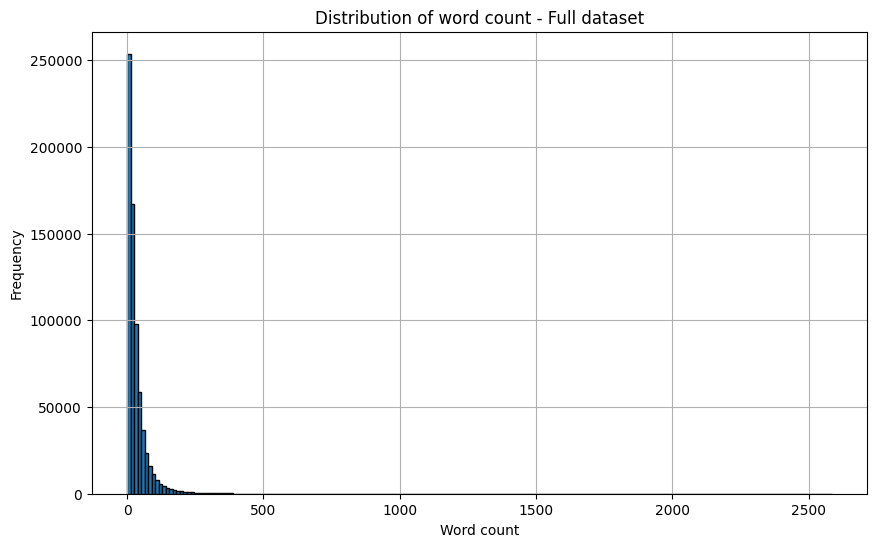

In [8]:
# Plot histogram of full dataset by review length

# Calculate the length of each text entry
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Compute the histogram and get the bin ranges
counts, bin_edges = np.histogram(df['word_count'], bins=200)

print("Counts:", counts)
print("Bin ranges:", bin_edges)

plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=bin_edges, edgecolor='black')
plt.title('Distribution of word count - Full dataset')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

* Notice that in full dataset there are very short reviews (sub 12 words) as well as very long (over 2500 words)
* Reviews not surprisingly are shorter rather than longer
* The information/training value of very short reviews and very long reviews is questionable. We might want to remove long outliers as well as very short reviews, because we will be using data to train model that has a purpose of extracting sentiment from longer pieces of text (paragraph).
* Ideal dataset should probably have a medium length review ~ from couple of sentences to short paragraph - **this is assumption and yet to be validated**



Number of rows in the filtered vs full datasets: 340669:701528
Occurance counts: [12905 12089 11705 10978 10443 10067  9770  9125  8763     0  8368  8054
  7749  7438  7023  6879  6498  6333  6091     0  5786  5573  5332  5180
  4923  4837  4681  4560  4247     0  4151  4038  3843  3795  3584  3380
  3359  3215  3161     0  3012  2976  2713  2629  2581  2462  2435  2387
  2296     0  2211  2060  2003  2012  1878  1885  1847  1786  1661     0
  1666  1485  1590  1444  1443  1400  1324  1283  1289     0  1215  1265
  1219  1175  1140  1139  1111  1034  1029     0   950   884   945   896
   850   837   890   768   803     0   787   760   686   709   665   681
   634   675   593     0   629   586   579   591   572   572   532   498
   509     0   496   473   472   457   471   449   425   419   401     0
   413   406   400   387   351   357   330   369   329     0   368   332
   322   295   280   307   289   259   283     0   278   266   269   260
   240   243   244   231   248     0   247 

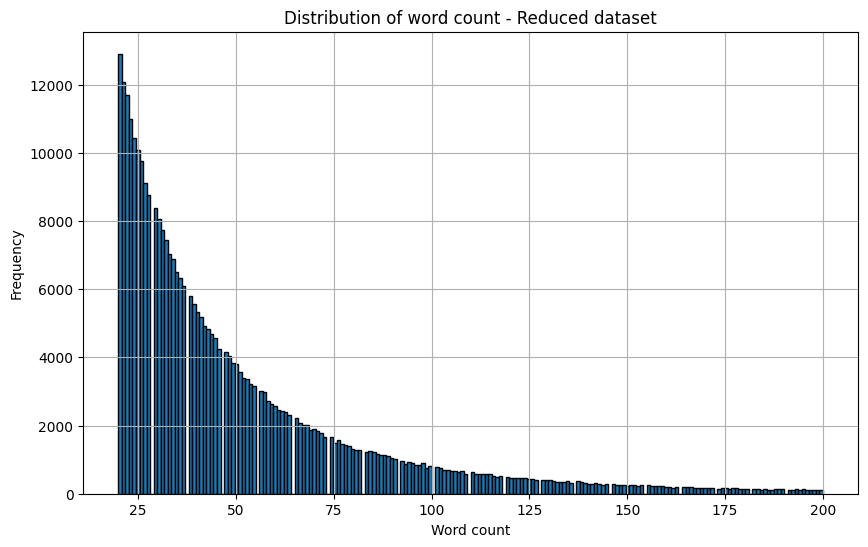

In [9]:
# Code for filtering out very short and very long reviews.
# Length range was selected arbitrary here.

length_from= 20
length_to = 200

filtered_df = df[(df['word_count'] >= length_from) & (df['word_count'] <= length_to)]

print(f"Number of rows in the filtered vs full datasets: {len(filtered_df)}:{len(df)}")

# Compute the histogram and get the bin ranges
counts, bin_edges = np.histogram(filtered_df['word_count'], bins=200)

print("Occurance counts:", counts)
print("Bin ranges:", bin_edges)

# Plot the histogram of text lengths
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=bin_edges, edgecolor='black')
plt.title('Distribution of word count - Reduced dataset')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Rating counts:
rating
1.0     51343
2.0     24468
3.0     32480
4.0     44817
5.0    187561
Name: count, dtype: int64


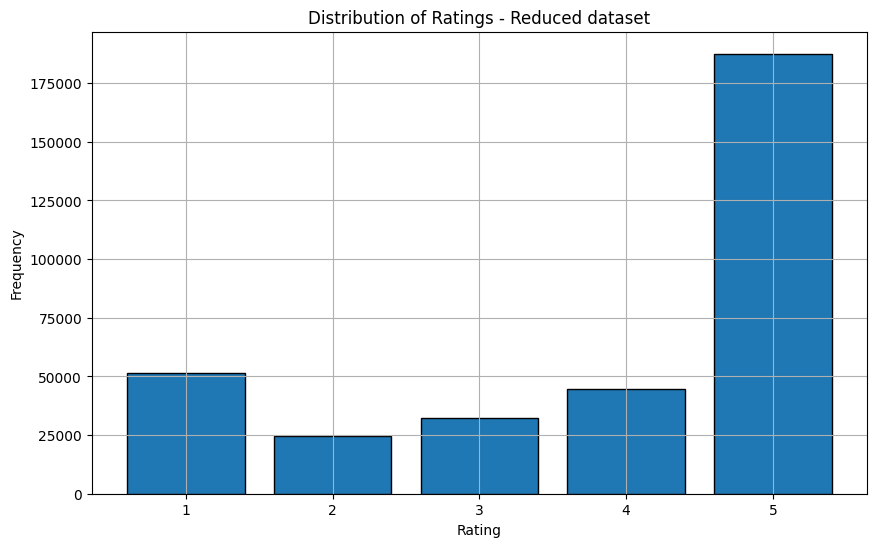

In [10]:
# Count the occurrences of each rating
rating_counts = filtered_df['rating'].value_counts().sort_index()

# Print the counts
print("Rating counts:")
print(rating_counts)

# Plot the distribution based on the "rating" field
plt.figure(figsize=(10, 6))
plt.bar(rating_counts.index, rating_counts.values, edgecolor='black')
plt.title('Distribution of Ratings - Reduced dataset')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(rating_counts.index)  # Ensure x-ticks show all possible ratings
plt.grid(True)
plt.show()

In the historgamn above we can see the balance of the filtered dataset. Dataset is **imbalanced** with 5 star reviews dominating. **We will have to balance dataset later.**

**Important question:** is there correlation between review length and rating? Maybe people write longer reviews when they are unhappy with product. This is important as we don't want to train model that will pick up length of the text as a factor impacting positivity/negativity.

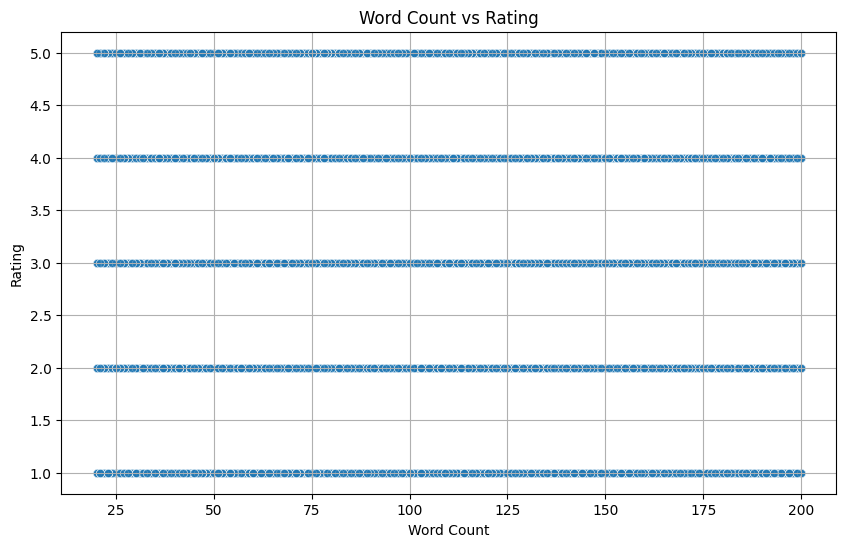

In [11]:
# Plot word_count vs rating
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['word_count'], filtered_df['rating'], alpha=0.7, edgecolors='w', linewidth=0.5)
plt.title('Word Count vs Rating')
plt.xlabel('Word Count')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

* Above test show that every rating have a spread of different word lengths.
* Is this is enough to show that the length of the review is not a factor in the rating? **No it is not.** Lets do a couple of more tests.

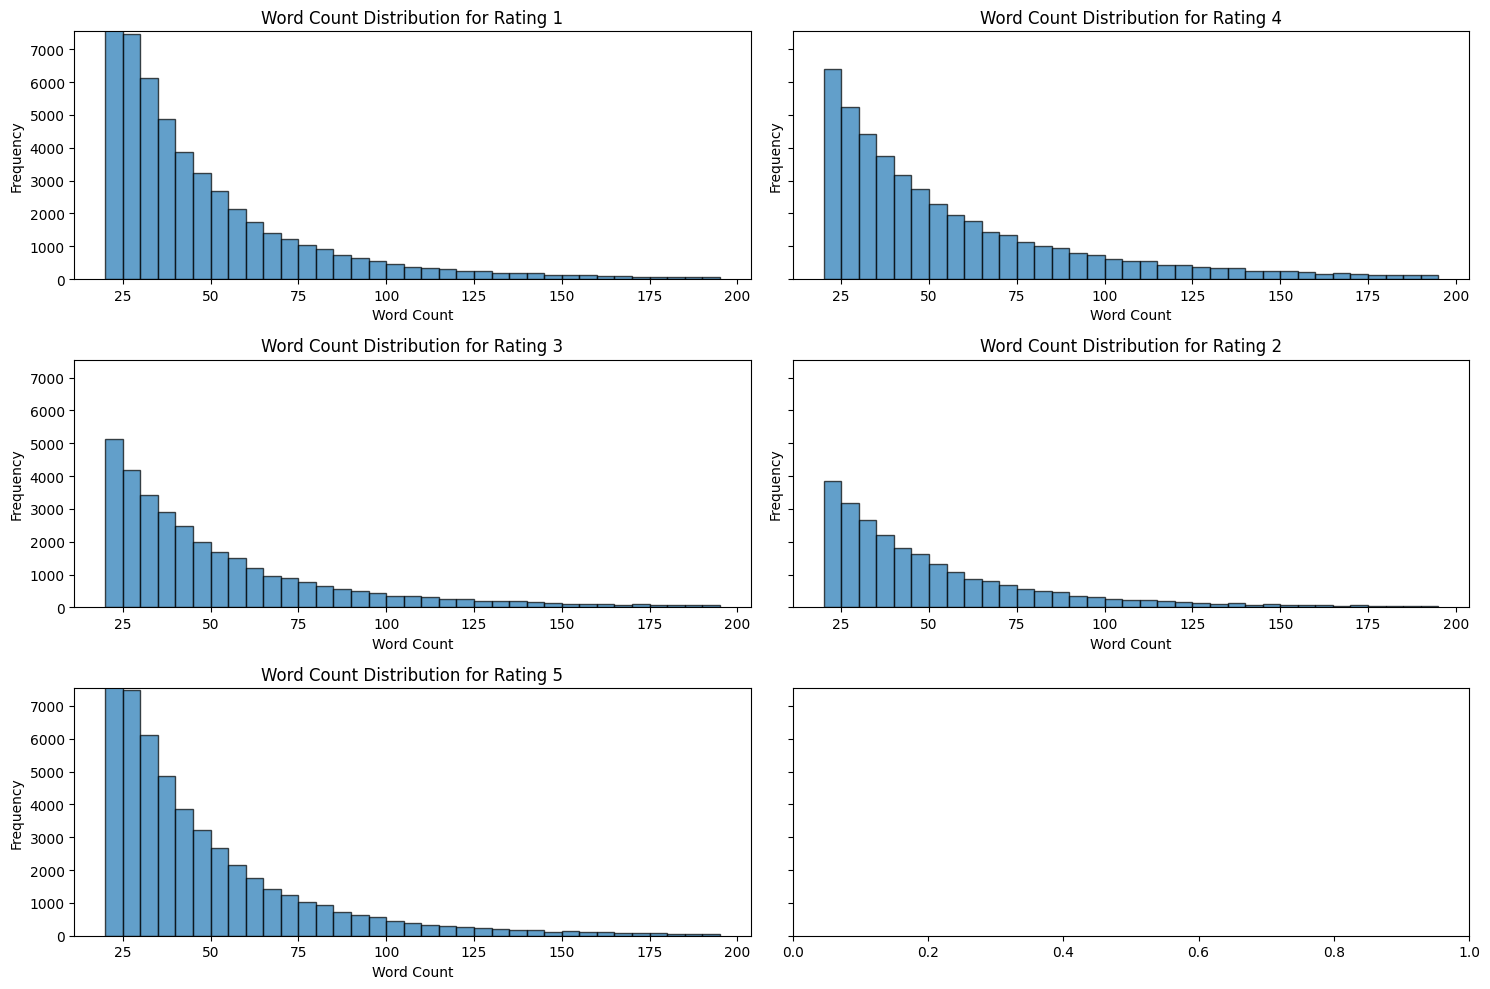

In [12]:
# Lets separate data based on the rating and visualise using histogram plots.

# Extract entries with a specific rating
rating_1_df = filtered_df[filtered_df['rating'] == 1]
rating_2_df = filtered_df[filtered_df['rating'] == 2]
rating_3_df = filtered_df[filtered_df['rating'] == 3]
rating_4_df = filtered_df[filtered_df['rating'] == 4]
rating_5_df = filtered_df[filtered_df['rating'] == 5]

fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharey=True)

# We will use this to use same y axis range for all sub-plots
y_max = max(
    rating_5_df['word_count'].value_counts().max(),
    rating_4_df['word_count'].value_counts().max(),
    rating_3_df['word_count'].value_counts().max(),
    rating_2_df['word_count'].value_counts().max(),
    rating_1_df['word_count'].value_counts().max()
)

axes[0, 0].set_ylim(0, y_max)

# Plot individual subplots

# Rating 1
plt.subplot(3, 2, 1)
plt.hist(rating_1_df['word_count'], bins=range(20, 200, 5), edgecolor='black', alpha=0.7)
plt.title('Word Count Distribution for Rating 1')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Rating 2
plt.subplot(3, 2, 4)
plt.hist(rating_2_df['word_count'], bins=range(20, 200, 5), edgecolor='black', alpha=0.7)
plt.title('Word Count Distribution for Rating 2')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Rating 3
plt.subplot(3, 2, 3)
plt.hist(rating_3_df['word_count'], bins=range(20, 200, 5), edgecolor='black', alpha=0.7)
plt.title('Word Count Distribution for Rating 3')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Rating 4
plt.subplot(3, 2, 2)
plt.hist(rating_4_df['word_count'], bins=range(20, 200, 5), edgecolor='black', alpha=0.7)
plt.title('Word Count Distribution for Rating 4')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Rating 5
plt.subplot(3, 2, 5)
plt.hist(rating_1_df['word_count'], bins=range(20, 200, 5), edgecolor='black', alpha=0.7)
plt.title('Word Count Distribution for Rating 5')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

* Above diagrams show similar distributions for all rating values (which is good), but they are not the same (but not expected to be exactly the same as well).
* This should be better visible in a boxplot.
* Also we can run additional statistical test to confirm.

Text(0, 0.5, 'Word Count')

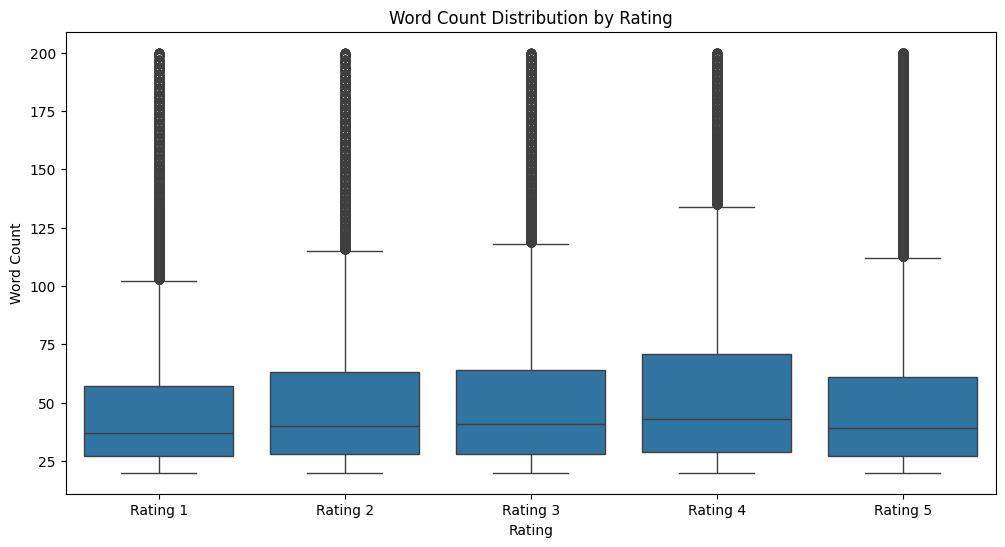

In [13]:
# Plot boxplots

combined_df = pd.concat([
    rating_1_df.assign(rating_label='Rating 1'),
    rating_2_df.assign(rating_label='Rating 2'),
    rating_3_df.assign(rating_label='Rating 3'),
    rating_4_df.assign(rating_label='Rating 4'),
    rating_5_df.assign(rating_label='Rating 5')
])

# Create boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(x='rating_label', y='word_count', data=combined_df)
plt.title('Word Count Distribution by Rating')
plt.xlabel('Rating')
plt.ylabel('Word Count')

Some descriptive statistics above - as **we dont have normal distribution** we will use median and interquantile ranges to compare.

* Medians and interquantiles look similar
* Shapes of distributions look similar



In [14]:
# Calculate stattistics for data groups split by rating
def calculate_statistics(df, rating):
    data = df['word_count']

    # Calculate some statistics
    median = np.median(data)
    percentiles = np.percentile(data, [25, 50, 75])

    # Print results
    print(f"Rating {rating} Statistics:")
    print(f"Median: {median}")
    print(f"25th, 50th (Median), 75th Percentiles: {percentiles}")
    print("-----------------------------------------")


calculate_statistics(rating_1_df, 1)
calculate_statistics(rating_2_df, 2)
calculate_statistics(rating_3_df, 3)
calculate_statistics(rating_4_df, 4)
calculate_statistics(rating_5_df, 5)

Rating 1 Statistics:
Median: 37.0
25th, 50th (Median), 75th Percentiles: [27. 37. 57.]
-----------------------------------------
Rating 2 Statistics:
Median: 40.0
25th, 50th (Median), 75th Percentiles: [28. 40. 63.]
-----------------------------------------
Rating 3 Statistics:
Median: 41.0
25th, 50th (Median), 75th Percentiles: [28. 41. 64.]
-----------------------------------------
Rating 4 Statistics:
Median: 43.0
25th, 50th (Median), 75th Percentiles: [29. 43. 71.]
-----------------------------------------
Rating 5 Statistics:
Median: 39.0
25th, 50th (Median), 75th Percentiles: [27. 39. 61.]
-----------------------------------------


Kruskal Wallis test assumptions (from https://www.statisticssolutions.com/kruskal-wallis-test/):
* It is assumed that the observations in the data set are independent of each other.
* It is assumed that the distribution of the population should not be necessarily normal and the variances should not be necessarily equal.
* It is assumed that the observations must be drawn from the population by the process of random sampling.

In [15]:
# Perform Kruskal-Wallis H Test
stat, p_value = kruskal(
    rating_1_df['word_count'],
    rating_2_df['word_count'],
    rating_3_df['word_count'],
    rating_4_df['word_count'],
    rating_5_df['word_count']
)

print('Kruskal-Wallis H Test')
print(f'Statistic: {stat}')
print(f'P-value: {p_value}')

Kruskal-Wallis H Test
Statistic: 1631.084946141135
P-value: 0.0


Since the p-value (0.0) is less than the commonly used significance level of 0.05, you reject the null hypothesis (The null hypothesis of the Kruskal-Wallis test states that the distributions of the groups are the same, i.e., there is no difference in the medians of the groups.). This means there is strong evidence to conclude that there are statistically significant differences in the word count distributions across the different rating groups.

In [16]:
# Extract word counts from each rating dataframe
word_counts_1 = rating_1_df['word_count']
word_counts_2 = rating_2_df['word_count']
word_counts_3 = rating_3_df['word_count']
word_counts_4 = rating_4_df['word_count']
word_counts_5 = rating_5_df['word_count']

# Combine data into a dictionary
data_dict = {
    'rating_1': word_counts_1,
    'rating_2': word_counts_2,
    'rating_3': word_counts_3,
    'rating_4': word_counts_4,
    'rating_5': word_counts_5
}

# Perform pairwise Wilcoxon tests
pairs = list(combinations(data_dict.keys(), 2))
p_values = []

for (group1, group2) in pairs:
    data1 = data_dict[group1]
    data2 = data_dict[group2]
    stat, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    p_values.append(p_value)
    print(f"Pairwise Wilcoxon Test between {group1} and {group2}: p-value = {p_value}")

Pairwise Wilcoxon Test between rating_1 and rating_2: p-value = 2.3050879905219855e-60
Pairwise Wilcoxon Test between rating_1 and rating_3: p-value = 2.39548430766215e-83
Pairwise Wilcoxon Test between rating_1 and rating_4: p-value = 1.8886447269293306e-301
Pairwise Wilcoxon Test between rating_1 and rating_5: p-value = 1.7518704029760638e-35
Pairwise Wilcoxon Test between rating_2 and rating_3: p-value = 0.18755168426824242
Pairwise Wilcoxon Test between rating_2 and rating_4: p-value = 2.7309832551458514e-48
Pairwise Wilcoxon Test between rating_2 and rating_5: p-value = 5.2193625178542595e-20
Pairwise Wilcoxon Test between rating_3 and rating_4: p-value = 4.9499365636714536e-46
Pairwise Wilcoxon Test between rating_3 and rating_5: p-value = 1.3797389445242788e-33
Pairwise Wilcoxon Test between rating_4 and rating_5: p-value = 7.078433223863774e-240


Finally we can run correlation test on the data. If there is positive or negative correlation between the length of comment and the rating this might impact the later training i.e. consistently longer texts fed into training model when the rating is negative. We want as little correlation as possible (text content should be parameter, not the text length).

Test below shows very small negative correlation on our dataset.

In [17]:
# Calculate Spearman rank correlation

spearman_corr, spearman_p = spearmanr(filtered_df['word_count'], filtered_df['rating'])
print("Spearman's rank correlation between word count and rating:", spearman_corr)
# print("Spearman's p-value:", spearman_p) # should not trust this as the data not normal

Spearman's rank correlation between word count and rating: -0.006257936290170601


**In summary:**
*   Data distribution (by review word count) resembles geometric/exponential distribution. It is not normal distribution, so statistical tools that assume this do not apply
*   If we split data by rating we can see that visually the distributions/histograms are very similar
*   Boxplots and median+interquantiles show very similar measures accross 5 different ratings groups
*   Kruskal-Wallis test followed by Pairwise Wilcoxon Test show that there is statisticaly significant difference between the groups - although it is not clear if this is important for the purposes of the sentiment detection model training.
* What is important is that groups are not balanced - "5.0" rated reviews are much more common that other groups - **in fact they are more common that all the rest groups summed together**. We probably want to get balanced datasets for model training.
* Spearman rank correlation was calculated and shows negligible rating and review length correlation, which is good - we dont need to do anything to fix this.

# Step 3 - Data Preparation



*   Cleanup - lematisation, stop word removal, punctuation mark removal from text. In general text samples removed show that text is clean enough, no html codes/tags, no emojis, no empty spaces were observed in random samples inspected.
*   Data split - split data into training and validation sets. Use training data sets to train models, use validation data sets to measure performance.



In [18]:
# Cleanup task to include:
# - replace any newline characters
# - replace any non-letter characters to spaces
# - replace all multi space chung to a single space
# - convert all letters to a lower case
# - remove stop words
# - lemmatise words

pandarallel.initialize(nb_workers=10, progress_bar=True)

nlp = spacy.load('en_core_web_sm')

def clean_text(text):
    t = text.replace('\\n', ' ') # replace newline with space
    t = re.sub(r'[^a-zA-Z]', ' ', t) # replace non-letter charactes to space
    t = re.sub(' +', ' ', t) # repalce all multi-space chunk into single space
    t = t.lower() # convert to lower letters

    # Remove stop words and lemmatise the rest
    doc = nlp(t)
    filtered_words = [token.lemma_ for token in doc if not token.is_stop]

    return filtered_words

# Apply the cleanup function to the specific columns
#filtered_df.loc[:, "clean_text"] = filtered_df['text'].iloc[0:10000].parallel_apply(clean_text)
filtered_df.loc[:, "clean_text"] = filtered_df['text'].parallel_apply(clean_text)


#filtered_df[['clean_text', 'rating']]


INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<ipython-input-18-f986172dfd3a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, "clean_text"] = filtered_df['text'].parallel_apply(clean_text)


In [19]:
# print out couple of cleaned text examples
print(filtered_df.iloc[1]["clean_text"])
print(filtered_df.iloc[10]["clean_text"])
print(filtered_df.iloc[100]["clean_text"])

['product', 'need', 'wish', 'odorless', 'soft', 'coconut', 'smell', 'have', 'head', 'smell', 'like', 'orange', 'coffee', 'offputte', 'grant', 'know', 'smell', 'describe', 'hope', 'light']
['nice', 'small', 'brush', 'nice', 'wood', 'boar', 'bristle', 'son', 'absolutely', 'love', 'brush', 'hair', 'keep', 'look', 'good', 'compact', 'size', 'make', 'nice', 'center', 'console', 'car', 'vacation', 'highly', 'recommend']
['popular', 'excited', 'try', 'don', 't', 'feel', 'like', 'hard', 'scalp', 'feel', 'easy', 'use', 'finger', 'maybe', 'need', 'practice', 'try', 'different', 'massager', 'look', 'like', 'picture']


In [20]:
# Data split

training_df, validation_df = train_test_split(filtered_df, test_size=0.2, stratify=filtered_df['rating'], random_state=42)

# Print the shapes to verify the split
print("Training Data:")
print(training_df.shape)
print(f"Training dataset distribution by {training_df['rating'].value_counts()}")


print("\nValidation Data:")
print(validation_df.shape)
print(f"\nValidation dataset distribution by {validation_df['rating'].value_counts()}")

validation_df['clean_text_merged'] = validation_df['clean_text'].apply(lambda x: ' '.join(x))

# Perform balancing by rating with oversampling
over_sampler = RandomOverSampler(random_state=42)
x_training_resampled, y_training_resampled = over_sampler.fit_resample(training_df[['clean_text']], training_df['rating'])

# Create DataFrames from resampled data
train_df_resampled = pd.DataFrame(x_training_resampled, columns=['clean_text'])
train_df_resampled['rating'] = y_training_resampled

print("\nTraining dataset distribution after oversampling:")
print(train_df_resampled.shape)
print(train_df_resampled['rating'].value_counts())
print(train_df_resampled['clean_text'])

train_df_resampled['clean_text_merged'] = train_df_resampled['clean_text'].apply(lambda x: ' '.join(x))

print(train_df_resampled['clean_text_merged'])


Training Data:
(272535, 13)
Training dataset distribution by rating
5.0    150049
1.0     41074
4.0     35854
3.0     25984
2.0     19574
Name: count, dtype: int64

Validation Data:
(68134, 13)

Validation dataset distribution by rating
5.0    37512
1.0    10269
4.0     8963
3.0     6496
2.0     4894
Name: count, dtype: int64

Training dataset distribution after oversampling:
(750245, 2)
rating
5.0    150049
4.0    150049
3.0    150049
1.0    150049
2.0    150049
Name: count, dtype: int64
0         [absolutely, love, keep, comb, bit, problem, t...
1         [metal, thumb, forefinger, need, type, rubber,...
2         [horrible, reaction, eye, cream, need, wash, e...
3         [love, case, close, hinki, clasp, get, wish, s...
4         [uneven, don, t, look, fit, finger, accordingl...
                                ...                        
750240    [far, device, work, great, battery, life, good...
750241    [think, vacuum, feature, beard, trimmer, gimmi...
750242    [problem, dark, 

# Step 4 - Modeling

# Step 4.1 - sentiment analysis using dictionary based approach

* We will be using VADER (Valence Aware Dictionary and sEntiment Reasoner) for
lexicon based approach.
* We will be using this as a basis/reference model
* Literature talks about these type of tools being less accurate for long texts and sensitive to the context.
* This can be confirmed by breaking validation dataset into different review length bins and applying analysis on different bins
* As this tool doent require training we can run the analysis on validation data imediately (we will be using validation data to make sure we run different analysis on the same dataset)

In [21]:
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def vader_sentiment(text_list):
    text_str = " ".join(text_list)
    scores = sid.polarity_scores(text_str)
    return scores

results_df = pd.DataFrame()

# Apply VADER sentiment analysis on each row
results_df["sentiment_scores"] = validation_df['clean_text'].apply(vader_sentiment)

# Extract compound score
results_df.loc[:, "compound_score"] = results_df['sentiment_scores'].apply(lambda x: x['compound'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [22]:
print(results_df)

                                         sentiment_scores  compound_score
553404  {'neg': 0.0, 'neu': 0.337, 'pos': 0.663, 'comp...          0.9300
179575  {'neg': 0.0, 'neu': 0.397, 'pos': 0.603, 'comp...          0.8442
582806  {'neg': 0.385, 'neu': 0.356, 'pos': 0.259, 'co...         -0.6003
341595  {'neg': 0.19, 'neu': 0.381, 'pos': 0.428, 'com...          0.8545
9284    {'neg': 0.0, 'neu': 0.63, 'pos': 0.37, 'compou...          0.9260
...                                                   ...             ...
508107  {'neg': 0.0, 'neu': 0.729, 'pos': 0.271, 'comp...          0.7717
375649  {'neg': 0.205, 'neu': 0.465, 'pos': 0.33, 'com...          0.5719
361305  {'neg': 0.0, 'neu': 0.51, 'pos': 0.49, 'compou...          0.9100
102292  {'neg': 0.0, 'neu': 0.511, 'pos': 0.489, 'comp...          0.7717
17291   {'neg': 0.155, 'neu': 0.603, 'pos': 0.242, 'co...          0.8834

[68134 rows x 2 columns]


One more thing to do is to fix the mapping of rating into sentiment values. Normally tools such as VADER will have sentiment values from -1 to 1 (continous), while dataset we analysing has range from 1 to 5 (descrete). As it is not possible to do 1-to-1 mapping due to different types of data, we still can force mapping using binning method.

In [23]:
# Define the bins and corresponding labels
bins = [-1.0, -0.6, -0.2, 0.2, 0.6, 1.0]
labels = [1.0, 2.0, 3.0, 4.0, 5.0]

# Map compound scores to discrete values
results_df.loc[:, "mapped_rating"] = pd.cut(results_df['compound_score'], bins=bins, labels=labels, include_lowest=True)

In [24]:
# Sneak peak to couple of the predictions
review_index = 8
print(validation_df.iloc[review_index]["text"])
print(validation_df.iloc[review_index]["clean_text"])
print(validation_df.iloc[review_index]["rating"])
print(results_df.iloc[review_index]["sentiment_scores"])
print(results_df.iloc[review_index]["compound_score"])
print(results_df.iloc[review_index]["mapped_rating"])

print("-------------")

review_index = 23
print(validation_df.iloc[review_index]["text"])
print(validation_df.iloc[review_index]["clean_text"])
print(validation_df.iloc[review_index]["rating"])
print(results_df.iloc[review_index]["sentiment_scores"])
print(results_df.iloc[review_index]["compound_score"])
print(results_df.iloc[review_index]["mapped_rating"])

The grid pattern on these make it really easy to get the correct length and shape. Much more accurate! I also love the natural shape of these dual forms. They pop off nice and clean.  Too. I use acrylic powders with these, and it works very well.
['grid', 'pattern', 'easy', 'correct', 'length', 'shape', 'accurate', 'love', 'natural', 'shape', 'dual', 'form', 'pop', 'nice', 'clean', 'use', 'acrylic', 'powder', 'work']
5.0
{'neg': 0.0, 'neu': 0.481, 'pos': 0.519, 'compound': 0.9337}
0.9337
5.0
-------------
okay.  not that awesome.  i guess too expensive for a case.  i'ii keep these but not really sure it's working for me
['okay', 'awesome', 'guess', 'expensive', 'case', 'ii', 'sure', 's', 'work']
3.0
{'neg': 0.0, 'neu': 0.376, 'pos': 0.624, 'compound': 0.8074}
0.8074
5.0


F1 score based on full validation data set.

In [25]:
# Calculate F1 score
f1 = f1_score(validation_df['rating'], results_df['mapped_rating'], average='weighted')

print(f'F1 Score: {f1}')


F1 Score: 0.4842952957905041


We can bin data based on the text length and see how VADER performs on different length text.

In [26]:
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def vader_sentiment(text_list):
    text_str = " ".join(text_list)
    scores = sid.polarity_scores(text_str)
    return scores

# Define the bins and labels (adjust bins according to your needs)
bins = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
labels = ['20-40', '40-60', '60-80', '80-100', '100-120', '120-140', '140-160', '160-180', '180-200']

# Create a new column 'word_count_bin' with the bin labels
validation_df['word_count_bin'] = pd.cut(validation_df['word_count'], bins=bins, labels=labels, right=False)

# Group by the bins and create a dictionary of DataFrames for each bin
bins_dict = {label: validation_df[validation_df['word_count_bin'] == label] for label in labels}

f1_scores = {}

# Apply VADER sentiment analysis to a  different review length groups
for label, df in bins_dict.items():
    results_df = pd.DataFrame()

    # Apply VADER sentiment analysis on each row
    results_df["sentiment_scores"] = df['clean_text'].apply(vader_sentiment)

    # Extract compound score
    results_df.loc[:, "compound_score"] = results_df['sentiment_scores'].apply(lambda x: x['compound'])

    # Define the bins and corresponding labels
    bins = [-1.0, -0.6, -0.2, 0.2, 0.6, 1.0]
    labels = [1.0, 2.0, 3.0, 4.0, 5.0]

    # Map compound scores to discrete values
    results_df.loc[:, "mapped_rating"] = pd.cut(results_df['compound_score'], bins=bins, labels=labels, include_lowest=True)

    f1 = f1_score(df['rating'], results_df['mapped_rating'], average='weighted')

    print(f'Bin:{label}, F1 Score: {f1}')

    f1_scores[label] = f1

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Bin:20-40, F1 Score: 0.4957674402900773
Bin:40-60, F1 Score: 0.4881906379339114
Bin:60-80, F1 Score: 0.47506096185423985
Bin:80-100, F1 Score: 0.4380857516686304
Bin:100-120, F1 Score: 0.44955860578087165
Bin:120-140, F1 Score: 0.4252173018578175
Bin:140-160, F1 Score: 0.43037373334290085
Bin:160-180, F1 Score: 0.4751543822766921
Bin:180-200, F1 Score: 0.4509223227168166


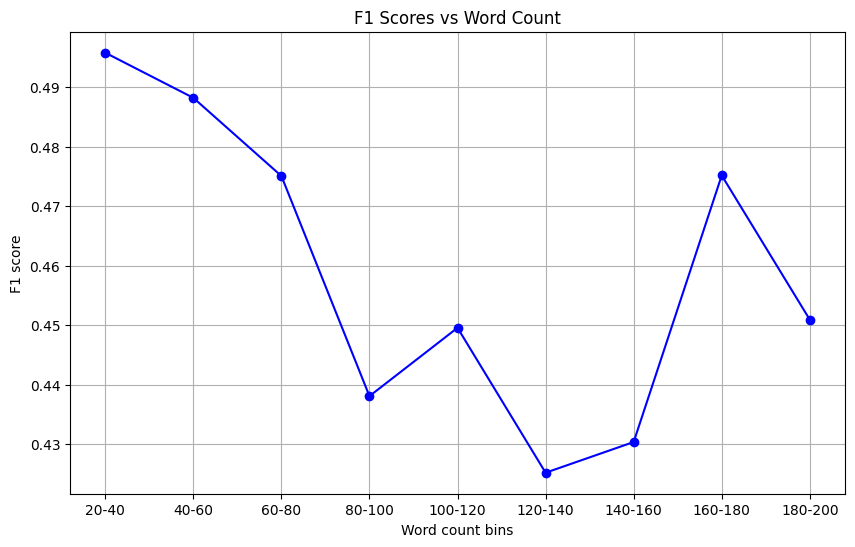

In [27]:
# Extract labels and scores
labels = list(f1_scores.keys())
scores = list(f1_scores.values())

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(labels, scores, marker='o', linestyle='-', color='b')

# Add title and labels to the axes
plt.title('F1 Scores vs Word Count')
plt.xlabel('Word count bins')
plt.ylabel('F1 score')

# Display the plot
plt.grid(True)
plt.show()

**Results above are inconclusive (no clear trend)  in terms of indicating the dependency of VADER accuracy to text length.**

# Step 4.2 - Sentiment analysis using TF-IDF based approaches with various classifiers

In [28]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

In [29]:
print(train_df_resampled['clean_text_merged'])

0         absolutely love keep comb bit problem tend tan...
1         metal thumb forefinger need type rubber preven...
2         horrible reaction eye cream need wash eye thor...
3         love case close hinki clasp get wish storage d...
4         uneven don t look fit finger accordingly cheap...
                                ...                        
750240    far device work great battery life good probab...
750241    think vacuum feature beard trimmer gimmick fig...
750242    problem dark spot topical cream like bremenn i...
750243    company great fast shipping product good make ...
750244    fit small wig cap stretch time good wig layer ...
Name: clean_text_merged, Length: 750245, dtype: object


In [30]:
pipeline.fit(train_df_resampled['clean_text_merged'], train_df_resampled['rating'])

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [31]:
predictions = pipeline.predict(validation_df['clean_text_merged'])
f1 = metrics.f1_score(validation_df['rating'], predictions, average='weighted')
print(f"F1 score: {f1:.4f}")

F1 score: 0.5794


In [32]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators=10, verbose=10, random_state=42))
])

In [33]:
pipeline.fit(train_df_resampled['clean_text_merged'], train_df_resampled['rating'])

building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.0min


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  4.0min


building tree 5 of 10
building tree 6 of 10
building tree 7 of 10


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:  7.0min


building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 RandomForestClassifier(n_estimators=10, random_state=42,
                                        verbose=10))])

In [34]:
predictions = pipeline.predict(validation_df['clean_text_merged'])
f1 = metrics.f1_score(validation_df['rating'], predictions, average='weighted')
print(f"F1 score: {f1:.4f}")

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.6s


F1 score: 0.5753


# Step 4.3 - Sentiment analysis using word embeddings

We will be using Word2Vec for converting the words to vectors.

In [35]:
# better to store the word2vec models somewhere more permanent - so there is no need to redownload/regenerate each time
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import os

#!mkdir mining_assignment # uncomment to create the folder
os.chdir("/content/drive/MyDrive/mining_assignment")
pwd_return = !pwd
WD_PATH = pwd_return[0] # path is returned as a list, we just need the string
print(f"Working directory: {WD_PATH}")

print("Folders/files in the current working directory:")
!ls

Working directory: /content/drive/MyDrive/mining_assignment
Folders/files in the current working directory:
gensim-data  sample_article.txt  word2vec_custom.bin


1) custom trained word2vec model based on the dataset - could perform better, but we have to train one for ourselves, size of our dataset might be too small to get a good word2vec model

In [37]:
# !!! Only runs if you don't have the model generated yet

# Check if the file exists
if os.path.exists(WD_PATH+"/word2vec_custom.bin"):
    print("Custom word2vec model file exists.")
else:
    print("Custom word2vec model file does not exist.")

    # initialise custom Word2Vec
    word2vec_custom = Word2Vec(
        sentences=training_df["clean_text"],
        vector_size=150,
        window=10,
        min_count=2,
        workers=4)

    # Save the trained model
    word2vec_custom.save(WD_PATH+"/word2vec_custom.bin")

Custom word2vec model file exists.


In [38]:
# Load pre-trained Word2Vec model
word2vec_custom = Word2Vec.load(WD_PATH+"/word2vec_custom.bin")

In [39]:
w1 = "good"
word2vec_custom = word2vec_custom.wv # get keyed vectors, this what will be used later
word2vec_custom.similar_by_word(w1)  # show most similar words to w1

[('great', 0.7793089747428894),
 ('decent', 0.7048121094703674),
 ('nice', 0.615023672580719),
 ('well', 0.5924717783927917),
 ('fantastic', 0.5450891256332397),
 ('amazing', 0.5332275032997131),
 ('ok', 0.5270953178405762),
 ('bad', 0.5053016543388367),
 ('excellent', 0.49685919284820557),
 ('like', 0.48515021800994873)]

2) or use existing pretrained word2vec embedings model - less effort, less computation, off the shelf model.

In [40]:
# !!! Only runs if you dont have the model downloaded yet

# Check if the file exists
if os.path.exists("/content/drive/MyDrive/mining_assignment/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"):
    print("Pretrained word2vec model file exists.")
else:
    print("Pretrained word2vec model file does not exist.")
    path = api.load("word2vec-google-news-300", return_path=True)
    print(path)

    !cp -r /root/gensim-data/ /content/drive/MyDrive/mining_assignment

Pretrained word2vec model file exists.


In [41]:
W2V_GOOGLE_PATH = "/content/drive/MyDrive/mining_assignment/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"

# Load the Word2Vec model
word2vec_google = KeyedVectors.load_word2vec_format(W2V_GOOGLE_PATH, binary=True)

In [42]:
w1 = "bad"
word2vec_google.similar_by_word(w1) # show most similar words to w1

[('good', 0.7190051674842834),
 ('terrible', 0.6828612089157104),
 ('horrible', 0.6702597737312317),
 ('Bad', 0.669891893863678),
 ('lousy', 0.6647640466690063),
 ('crummy', 0.567781925201416),
 ('horrid', 0.5651682615280151),
 ('awful', 0.5527253150939941),
 ('dreadful', 0.5526429414749146),
 ('horrendous', 0.5445998311042786)]

What word2vec does is converts the word to vector such as:

In [43]:
word2vec_google["bad"]

array([ 0.06298828,  0.12451172,  0.11328125,  0.07324219,  0.03881836,
        0.07910156,  0.05078125,  0.171875  ,  0.09619141,  0.22070312,
       -0.04150391, -0.09277344, -0.02209473,  0.14746094, -0.21582031,
        0.15234375,  0.19238281, -0.05078125, -0.11181641, -0.3203125 ,
        0.00506592,  0.15332031, -0.02563477, -0.0234375 ,  0.36328125,
        0.20605469,  0.04760742, -0.02624512,  0.09033203,  0.00457764,
       -0.15332031,  0.06591797,  0.3515625 , -0.12451172,  0.03015137,
        0.16210938,  0.00242615, -0.02282715,  0.02978516,  0.00531006,
        0.25976562, -0.22460938,  0.29492188, -0.18066406,  0.07910156,
        0.02282715,  0.12109375, -0.17382812, -0.03735352, -0.06933594,
       -0.21972656,  0.1875    , -0.03320312, -0.06225586, -0.04492188,
        0.11621094, -0.23339844, -0.11669922,  0.09814453, -0.11962891,
        0.13964844,  0.28710938, -0.26953125, -0.05493164,  0.03112793,
       -0.05029297,  0.1328125 , -0.01831055, -0.37695312, -0.06

Obviously there is a size difference between two models:

In [44]:
custom_len = len(word2vec_custom)
google_len = len(word2vec_google)

print(f"Custom vocab: {custom_len}")
print(f"Google vocab: {google_len}")

Custom vocab: 27984
Google vocab: 3000000


In [45]:
class ColumnReshaper(BaseEstimator, TransformerMixin):
    """Select only specified columns."""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reshape(-1, 1)

# Custom transformer to convert text to embeddings
class WordEmbeddingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec_model):
        self.word2vec_model = word2vec_model
        self.dim = word2vec_model.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        embedded_texts = []
        for text in X:
            embedded_text = np.zeros(self.dim)
            count = 0
            for word in text.split():
                if word in self.word2vec_model:
                    embedded_text += self.word2vec_model[word]
                    count += 1
            if count != 0:
                embedded_text /= count
            embedded_texts.append(embedded_text)
        return np.array(embedded_texts)

In [46]:
# Custom Word2Vec
pipeline = Pipeline([
    ('embedding', WordEmbeddingTransformer(word2vec_custom)),
    #('embedding', WordEmbeddingTransformer(word2vec_google)),
    ('classifier', RandomForestClassifier(n_estimators=10, verbose=10, random_state=42, class_weight='balanced'))
])

In [47]:
pipeline.fit(train_df_resampled['clean_text_merged'], train_df_resampled['rating'])

building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   15.4s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  1.0min


building tree 5 of 10
building tree 6 of 10
building tree 7 of 10


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:  1.8min


building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


Pipeline(steps=[('embedding',
                 WordEmbeddingTransformer(word2vec_model=<gensim.models.keyedvectors.KeyedVectors object at 0x7d3c528e5000>)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=10, random_state=42,
                                        verbose=10))])

In [48]:
predictions = pipeline.predict(validation_df['clean_text_merged'])
f1 = metrics.f1_score(validation_df['rating'], predictions, average='weighted')
print(f"F1 score: {f1:.4f}")

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.2s


F1 score: 0.5580


In [49]:
# Google Word2Vec
pipeline = Pipeline([
    # ('embedding', WordEmbeddingTransformer(word2vec_custom)),
    ('embedding', WordEmbeddingTransformer(word2vec_google)),
    ('classifier', RandomForestClassifier(n_estimators=10, verbose=10, random_state=42, class_weight='balanced'))
])

In [50]:
pipeline.fit(train_df_resampled['clean_text_merged'], train_df_resampled['rating'])

building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   19.3s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  1.3min


building tree 5 of 10
building tree 6 of 10
building tree 7 of 10


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:  2.4min


building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


Pipeline(steps=[('embedding',
                 WordEmbeddingTransformer(word2vec_model=<gensim.models.keyedvectors.KeyedVectors object at 0x7d3c528e5a50>)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=10, random_state=42,
                                        verbose=10))])

In [51]:
predictions = pipeline.predict(validation_df['clean_text_merged'])
f1 = metrics.f1_score(validation_df['rating'], predictions, average='weighted')
print(f"F1 score: {f1:.4f}")

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s


F1 score: 0.5020


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.3s


# Step 4.4.1 - Sentiment analysis using TF-IDF and neural net based classifier

In [69]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MLPClassifier(hidden_layer_sizes=(40, 20, 10), max_iter=10, activation='relu', solver='adam', random_state=42, verbose=10))
])

In [70]:
pipeline.fit(train_df_resampled['clean_text_merged'], train_df_resampled['rating'])

Iteration 1, loss = 1.07496523
Iteration 2, loss = 0.76416657
Iteration 3, loss = 0.56596767
Iteration 4, loss = 0.43591816
Iteration 5, loss = 0.35346341
Iteration 6, loss = 0.29853278
Iteration 7, loss = 0.26015484
Iteration 8, loss = 0.23241557
Iteration 9, loss = 0.21069432
Iteration 10, loss = 0.19427391


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier',
                 MLPClassifier(hidden_layer_sizes=(40, 20, 10), max_iter=10,
                               random_state=42, verbose=10))])

In [71]:
predictions = pipeline.predict(validation_df['clean_text_merged'])
f1 = metrics.f1_score(validation_df['rating'], predictions, average='weighted')
print(f"F1 score: {f1:.4f}")

F1 score: 0.5834


# Step 4.4.2 - Sentiment analysis using word embeddings and neural net based classifier

In [72]:
pipeline = Pipeline([
    ('embedding', WordEmbeddingTransformer(word2vec_custom)),
    ('classifier', MLPClassifier(hidden_layer_sizes=(80, 40, 20), max_iter=100, activation='relu', solver='adam', random_state=42, verbose=10))
])

In [73]:
pipeline.fit(train_df_resampled['clean_text_merged'], train_df_resampled['rating'])

Iteration 1, loss = 1.21039367
Iteration 2, loss = 1.16930979
Iteration 3, loss = 1.14891383
Iteration 4, loss = 1.13210714
Iteration 5, loss = 1.11875841
Iteration 6, loss = 1.10752936
Iteration 7, loss = 1.09802827
Iteration 8, loss = 1.09054549
Iteration 9, loss = 1.08375953
Iteration 10, loss = 1.07801993
Iteration 11, loss = 1.07247331
Iteration 12, loss = 1.06775277
Iteration 13, loss = 1.06344328
Iteration 14, loss = 1.05921958
Iteration 15, loss = 1.05535215
Iteration 16, loss = 1.05268349
Iteration 17, loss = 1.04910155
Iteration 18, loss = 1.04655454
Iteration 19, loss = 1.04403824
Iteration 20, loss = 1.04123848
Iteration 21, loss = 1.03869618
Iteration 22, loss = 1.03717906
Iteration 23, loss = 1.03501266
Iteration 24, loss = 1.03274865
Iteration 25, loss = 1.03157072
Iteration 26, loss = 1.02982230
Iteration 27, loss = 1.02800017
Iteration 28, loss = 1.02632269
Iteration 29, loss = 1.02455716
Iteration 30, loss = 1.02301650
Iteration 31, loss = 1.02203089
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('embedding',
                 WordEmbeddingTransformer(word2vec_model=<gensim.models.keyedvectors.KeyedVectors object at 0x7d3c528e5000>)),
                ('classifier',
                 MLPClassifier(hidden_layer_sizes=(80, 40, 20), max_iter=100,
                               random_state=42, verbose=10))])

In [57]:
predictions = pipeline.predict(validation_df['clean_text_merged'])
f1 = metrics.f1_score(validation_df['rating'], predictions, average='weighted')
print(f"F1 score: {f1:.4f}")

F1 score: 0.5892


# 4.5 - Hyperparameter tuning (explore all pipelines tried before)

Assuming sufficient computational resources one could run extensive search accross different pipeline parameters. Unfortunately requires quite long time to execute as the parameter space explodes very quickly. So code below was never executed fully.

In [58]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report

# # Define the parameter grid
# param_grid_tfidf = [
#     {
#         #'vect__max_features': [1000, 2000, 3000],
#         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],

#         # 'tfidf__use_idf': [True, False],
#         # 'tfidf__norm': ['l1', 'l2', None],

#         'clf': [RandomForestClassifier()],
#         'clf__verbose': [10],
#         'clf__random_state': [42],
#         'clf__n_estimators': [10],
#         'clf__class_weight': [None, 'balanced']
#     },

#     {
#         'vect__max_features': [1000, 2000, 3000],
#         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],

#         'tfidf__use_idf': [True, False],
#         'tfidf__norm': ['l1', 'l2', None],

#         'clf': [MultinomialNB()],
#         'clf__verbose': [10],
#         'clf__random_state': [42],
#         'clf__fit_prior': [True, False]
#     },

#     {
#         'vect__max_features': [1000, 2000, 3000],
#         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],

#         'tfidf__use_idf': [True, False],
#         'tfidf__norm': ['l1', 'l2', None],

#         'clf': [MLPClassifier(max_iter=100)],
#         'clf__verbose': [10],
#         'clf__random_state': [42],
#         'clf__hidden_layer_sizes': [(80, 40, 20), (40, 20, 10, 5)],
#         'clf__learning_rate': ['adaptive']
#     }

# ]

# param_grid_w2v = [

#     {
#         'vect__max_features': [1000, 2000, 3000],
#         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],

#         # 'tfidf__use_idf': [True, False],
#         # 'tfidf__norm': ['l1', 'l2', None],

#         'clf': [RandomForestClassifier()],
#         'clf__verbose': [10],
#         'clf__random_state': [42],
#         'clf__n_estimators': [10, 20],
#         'clf__class_weight': [None, 'balanced']
#     },

#     {
#         'vect__max_features': [1000, 2000, 3000],
#         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],

#         'tfidf__use_idf': [True, False],
#         'tfidf__norm': ['l1', 'l2', None],

#         'clf': [MultinomialNB()],
#         'clf__verbose': [10],
#         'clf__random_state': [42],
#         'clf__fit_prior': [True, False]
#     },

#     {
#         'vect__max_features': [1000, 2000, 3000],
#         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],

#         'tfidf__use_idf': [True, False],
#         'tfidf__norm': ['l1', 'l2', None],


#         'clf': [MLPClassifier(max_iter=100)],
#         'clf__verbose': [10],
#         'clf__random_state': [42],
#         'clf__hidden_layer_sizes': [(80, 40, 20), (40, 20, 10, 5)],
#         'clf__learning_rate': ['adaptive']
#     }
# ]

# pipeline_tfidf = Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer()),
#     ('clf', None)
# ])

# pipeline_w2v_custom = Pipeline([
#     ('w2v', WordEmbeddingTransformer(word2vec_custom)),
#     ('clf', None)
# ])

# pipeline_w2v_google = Pipeline([
#     ('w2v', WordEmbeddingTransformer(word2vec_google)),
#     ('clf', None)
# ])


# # Grid search with TFIDF
# grid_search_tfidf = GridSearchCV(pipeline_tfidf, param_grid_tfidf, scoring='f1', n_jobs=-1, verbose=10)
# grid_search_tfidf.fit(training_df['text'], training_df['rating'])

# # Grid search with Word2Vec - custom
# grid_search_w2v_custom = GridSearchCV(pipeline_w2v_custom, param_grid_w2v, scoring='f1', n_jobs=-1, verbose=10)
# grid_search_w2v_custom.fit(training_df['text'], training_df['rating'])

# # Grid search with Word2Vec - google
# grid_search_w2v_google = GridSearchCV(pipeline_w2v_google, param_grid_w2v, scoring='f1', n_jobs=-1, verbose=10)
# grid_search_w2v_google.fit(training_df['text'], training_df['rating'])

# # Output the best parameters and scores
# print("Best parameters (TFIDF):", grid_search_tfidf.best_params_)
# print("Best score (TFIDF):", grid_search_tfidf.best_score_)

# print("Best parameters (Word2Vec custom):", grid_search_w2v_custom.best_params_)
# print("Best score (Word2Vec custom):", grid_search_w2v_custom.best_score_)

# print("Best parameters (Word2Vec google):", grid_search_w2v_google.best_params_)
# print("Best score (Word2Vec google):", grid_search_w2v_google.best_score_)

# 5 - Analysis of the model

In [74]:
print("Classification Report:\n", classification_report(validation_df['rating'], predictions))
print("Confusion Matrix:\n", confusion_matrix(validation_df['rating'], predictions))


Classification Report:
               precision    recall  f1-score   support

         1.0       0.57      0.56      0.57     10269
         2.0       0.20      0.22      0.21      4894
         3.0       0.22      0.25      0.24      6496
         4.0       0.26      0.34      0.29      8963
         5.0       0.81      0.73      0.77     37512

    accuracy                           0.57     68134
   macro avg       0.41      0.42      0.41     68134
weighted avg       0.60      0.57      0.58     68134

Confusion Matrix:
 [[ 5726  1661  1265   708   909]
 [ 1453  1082   972   704   683]
 [  997  1061  1643  1497  1298]
 [  532   650  1357  3018  3406]
 [ 1260  1080  2088  5834 27250]]


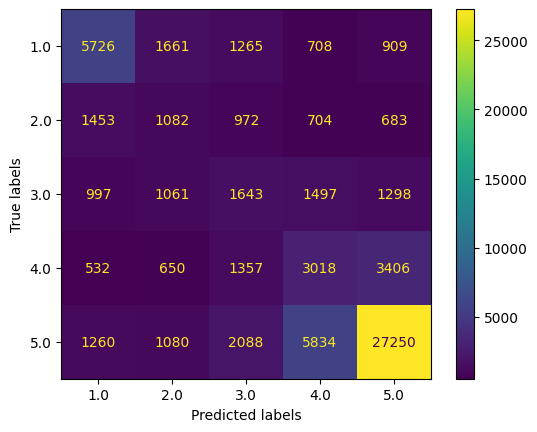

In [77]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(validation_df['rating'], predictions)
ConfusionMatrixDisplay(cm).plot()

labels = np.unique(validation_df['rating'])
plt.xticks(range(len(labels)), labels)
plt.yticks(range(len(labels)), labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

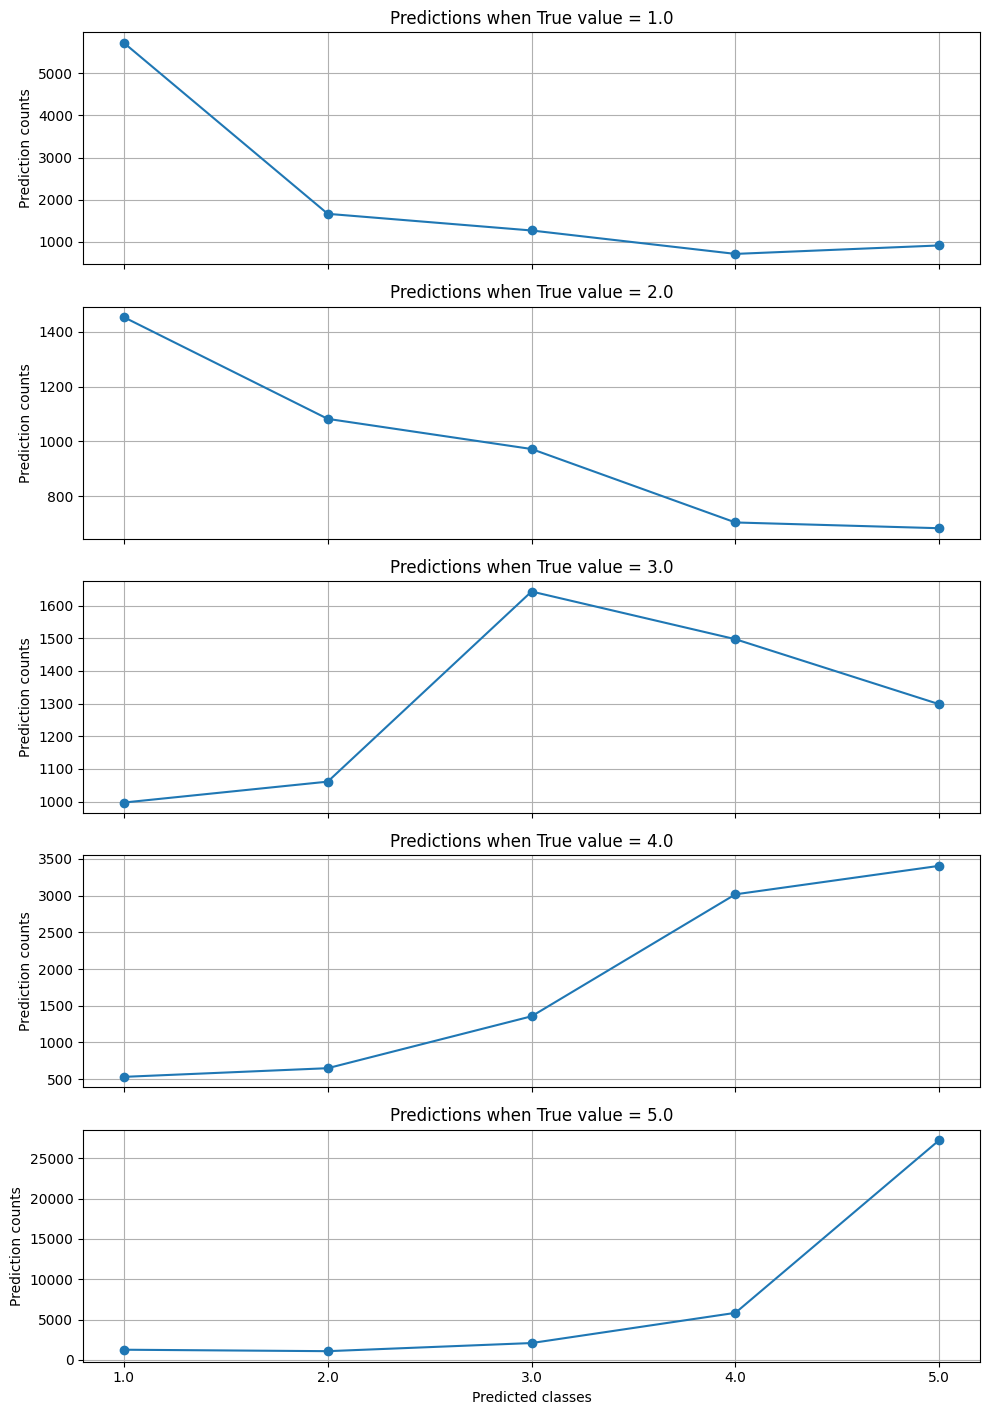

In [78]:
# Plot each row in confusion matrix, where row=true value, columns=predicted values

num_rows = cm.shape[0] # number of rows in confusuion matrix = number of subplots

figure, axis = plt.subplots(num_rows, 1, figsize=(10, 15), sharex=True)
plt.xlabel('Predicted classes')

x_labels = ['1.0', '2.0', '3.0', '4.0', '5.0']


for i in range(num_rows):
    axis[i].plot(cm[i], marker='o', linestyle='-')
    axis[i].set_title(f'Predictions when True value = {i+1}.0')
    axis[i].set_ylabel('Prediction counts')
    axis[i].set_xticks(range(len(x_labels)))
    axis[i].set_xticklabels(x_labels)
    axis[i].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 6 - Best performing model example deployment

As examplar we will use the electric toothbrush review from here: https://www.techradar.com/reviews/oral-b-io-series-10

Text was manually cleaned into a paragraphs, titles of the sections were removed as well as any photo labels, etc. Just pure text paragraphs were left for analysis.

We will apply the sentiment analysis on the text once on each individual paragraphs. The total article sentiment analysis will be an agregate of the constituent paragraph scores (there are 30 paragraphs in total)

The article provides a rating for the reviewed product as 4.5 stars and while one article is not enough to prove the algorithm performance, its a good demostration on how such algorithm could be applied in real world scenario.

In [79]:
# Path to the text file
file_path = "/content/drive/MyDrive/mining_assignment/sample_article.txt"

# Read the file and create a list of lines
with open(file_path, 'r') as file:
    lines = file.readlines()

lines = [line.strip() for line in lines]

df_sample_text = pd.DataFrame(lines, columns=['text'])
print(df_sample_text)

                                                 text
0   The Oral-B iO Series 10 is a high-priced but s...
1   This is our full review of the Oral-B iO Serie...
2   A big new feature over previous models is a ma...
3   The Series 10 uses a brushless magnetic motor,...
4   But that hefty price tag does put it apart fro...
5   The short answer is that, if you can afford it...
6   The Oral-B iO Series 10 is out now in the US, ...
7   The Oral-B iO Series 10 continues on from the ...
8   At the base is a metallic finish with an inden...
9   The travel case comes with enough space for th...
10  The body is devoid of any grip material which ...
11  At the top of the brush, before the brush head...
12  The Oral-B iO Series 10 is packed with feature...
13  The brush is backed by a helpful app which let...
14  While the light ring on the toothbrush is a fu...
15  The seven modes offer plenty of brushing optio...
16  The dock itself will connect to WiFi to displa...
17  A very powerful feature 

In [80]:
# Cleanup task to include:
# - replace any newline characters
# - replace any non-letter characters to spaces
# - replace all multi space chung to a single space
# - convert all letters to a lower case
# - remove stop words
# - lemmatise words

pandarallel.initialize(nb_workers=10, progress_bar=True)

nlp = spacy.load('en_core_web_sm')

def clean_text(text):
    t = text.replace('\\n', ' ') # replace newline with space
    t = re.sub(r'[^a-zA-Z]', ' ', t) # replace non-letter charactes to space
    t = re.sub(' +', ' ', t) # repalce all multi-space chunk into single space
    t = t.lower() # convert to lower letters

    # Remove stop words and lemmatise the rest
    doc = nlp(t)
    filtered_words = [token.lemma_ for token in doc if not token.is_stop]

    return filtered_words

# Apply the cleanup function to the specific columns
df_sample_text.loc[:, "clean_text"] = df_sample_text['text'].parallel_apply(clean_text)


df_sample_text['clean_text_merged'] = df_sample_text['clean_text'].apply(lambda x: ' '.join(x))

print(df_sample_text)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


                                                 text  \
0   The Oral-B iO Series 10 is a high-priced but s...   
1   This is our full review of the Oral-B iO Serie...   
2   A big new feature over previous models is a ma...   
3   The Series 10 uses a brushless magnetic motor,...   
4   But that hefty price tag does put it apart fro...   
5   The short answer is that, if you can afford it...   
6   The Oral-B iO Series 10 is out now in the US, ...   
7   The Oral-B iO Series 10 continues on from the ...   
8   At the base is a metallic finish with an inden...   
9   The travel case comes with enough space for th...   
10  The body is devoid of any grip material which ...   
11  At the top of the brush, before the brush head...   
12  The Oral-B iO Series 10 is packed with feature...   
13  The brush is backed by a helpful app which let...   
14  While the light ring on the toothbrush is a fu...   
15  The seven modes offer plenty of brushing optio...   
16  The dock itself will connec

In [81]:
predictions = pipeline.predict(df_sample_text['clean_text_merged'])
print(predictions)

[5. 5. 3. 5. 5. 3. 4. 2. 2. 4. 5. 3. 4. 5. 3. 5. 3. 3. 4. 4. 5. 4. 4. 4.
 3. 5. 5. 1. 4.]


Mean: 3.8620689655172415
Median: 4.0
Variance: 1.1533888228299645
Percentiles (25th, 50th, 75th): [3. 4. 5.]


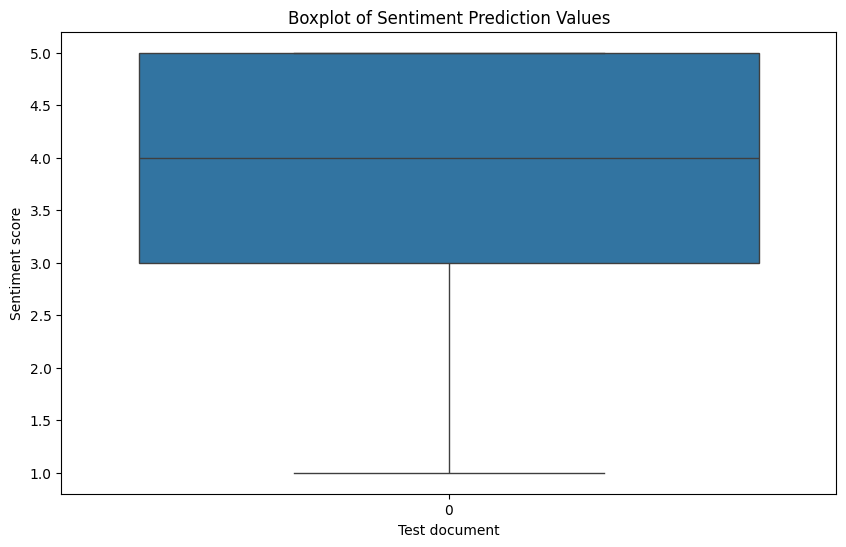

In [83]:
mean_value = np.mean(predictions)
median_value = np.median(predictions)
variance_value = np.var(predictions)
percentiles = np.percentile(predictions, [25, 50, 75])

print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Variance: {variance_value}")
print(f"Percentiles (25th, 50th, 75th): {percentiles}")

df = pd.DataFrame(predictions)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title('Boxplot of Sentiment Prediction Values')
plt.xlabel('Test document')
plt.ylabel('Sentiment score')
plt.show()

Note, how the actual value authors of the article assigned to the product is 4.5 and our model prediction 3.86 (median), 4.0 (mean) with variance of 1.15.